In [2]:
import tensorflow as tf
print ("TensorFlow version: " + tf.__version__)

C:\Users\josep\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow version: 1.11.0


In [3]:
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tensorflow import keras
import scipy
import time

# Prob 1

In [4]:
#Import RCV1 Dataset - will be imported as Compressed Sparse Row format (CSR)
# rcv1.data = data matrix (articles x features)
# rcv1.target = topics matrix (articles x topics)
# CCAT topic is column 33 in rcv1.target
from sklearn.datasets import fetch_rcv1
rcv1 = fetch_rcv1()

## Part 1a - Label Vector Creation

In [5]:
article_num = len(rcv1.target.indptr)

#find indices of rows that have a nonzero element in column 33 = CCAT
ccat_col_indices = [index for index,col in list(enumerate(rcv1.target.indices)) if col == 33]

label_vect_list = []
j = 0
#now need to map these column indices to corresponding articles in target
for i in range(article_num):
    #finsihed classifying all indices
    if j == len(ccat_col_indices):
        #label the rest of the articles -1
        label_vect_list.append(-1)
    else:
        if i == article_num-1 and ccat_col_indices[j] >= rcv1.target.indptr[i]:
            label_vect_list.append(1)
            j += 1
        elif ccat_col_indices[j] >= rcv1.target.indptr[i] and ccat_col_indices[j] < rcv1.target.indptr[i+1]:
            label_vect_list.append(1)
            j += 1
        else:
            label_vect_list.append(-1)
            
#convert from list to numpy array
label_vect = np.array(label_vect_list)

#check to ensure label vect was populated correctly
errors = []
label_indx = [index for index,label in list(enumerate(label_vect)) if label == 1]
j=0
for index in label_indx:
    if not (ccat_col_indices[j] >= rcv1.target.indptr[index] and ccat_col_indices[j] < rcv1.target.indptr[index+1]):
        errors.append(index)
    j+=1
if(not errors):
    print("label_vect initialized correctly")

label_vect initialized correctly


## Part 1b - Training and Test Data Parsing

In [6]:
#Segment out training set and test set
training_len = 100000

In [7]:
training_data_labels = label_vect[0:training_len]
training_data_indptr = rcv1.data.indptr[0:training_len]
training_data_data = rcv1.data.data[0:training_data_indptr[training_len-1]]
training_data_indices = rcv1.data.indices[0:training_data_indptr[training_len-1]]

test_data_labels = label_vect[training_len:article_num]
test_data_indptr = rcv1.data.indptr[training_len:article_num]
test_data_len = len(test_data_labels)
test_data_indices = rcv1.data.indices[test_data_indptr[0]:test_data_indptr[test_data_len-1]]
test_data_data = rcv1.data.data[test_data_indptr[0]:test_data_indptr[test_data_len-1]]

# Prob 2 - PEGASOS

## Parameter Analysis - Lambda and Min_batch size

In [277]:
#PEGASOS Parameters - Regularization (lambda), iterations (T), min-batch size(batch_size)
#Will run analysis analysis on all the parameters to check what the optimal point is.
#each graph will be training error vs number of iterations

T = 1000 #Fix iteration to analyze parameters 
pegasos_lambda_range = [10**(-5),10**(-4),10**(-3),10**(-2),10**(-1)]
min_batch_percent_range = [10**(-5),10**(-4),10**(-3),10**(-2),10**(-1)] #percent of training set to use as min-batch
weight_length = max(rcv1.data.indices)+1

#calculate the lengths of the articles rows.
training_data_row_length = np.diff(training_data_indptr)
#append the length of the last article
training_data_row_length = np.append(training_data_row_length,len(training_data_indices)-training_data_indptr[len(training_data_indptr)-1])

error_matrix = np.zeros((len(pegasos_lambda_range),len(min_batch_percent_range)))
pegasos_index = 0
                        
for pegasos_lambda in pegasos_lambda_range:
    min_batch_index = 0
    for min_batch_percent in min_batch_percent_range:
        print('lambda: ',pegasos_lambda,'min_batch: ',min_batch_percent)
        #Choose random subset of training , initialize weight to zero
        subset_length = int(min_batch_percent*training_len)
        w_pegasos = np.zeros(weight_length)
        for i in range(T):
            #adjust from i = 0:T-1 to i=1:T
            i += 1
            #choose random subset of artciles to use as min batch
            A_t = np.random.choice(training_len-1,subset_length)
    
            #initialize variable for sum of rows in A_t_dag
            grad_sum = np.zeros(weight_length)
            for index in A_t:
                row_data = training_data_data[training_data_indptr[index]:training_data_indptr[index]+training_data_row_length[index]]
                row_data_indices = training_data_indices[training_data_indptr[index]:training_data_indptr[index]+training_data_row_length[index]]
            
                #only dealing with weights corresponding to indices that are in this row. Update happens on these indices, then are
                # placed back into the overall w
                w_pegasos_row = w_pegasos[row_data_indices]
            
            
                if training_data_labels[index]*np.inner(w_pegasos_row,row_data) < 1:
                    grad_sum[row_data_indices] += training_data_labels[index]*row_data
        
            grad = pegasos_lambda*w_pegasos - (1/subset_length)*grad_sum
            eta = 1/(i*pegasos_lambda)
            w_pegasos_t_prime = w_pegasos - eta*grad
            w_pegasos = min(1,((1/np.sqrt(pegasos_lambda))/np.sqrt(np.inner(w_pegasos_t_prime,w_pegasos_t_prime))))*w_pegasos_t_prime
        
        errors = 0
        for i in range(training_len):
            row_data = training_data_data[training_data_indptr[i]:training_data_indptr[i]+training_data_row_length[i]]
            row_data_indices = training_data_indices[training_data_indptr[i]:training_data_indptr[i]+training_data_row_length[i]]
            
            #only dealing with weights corresponding to indices that are in this row. Update happens on these indices, then are
            # placed back into the overall w
            w_pegasos_row = w_pegasos[row_data_indices]
    
    
            pred = np.sign(np.inner(w_pegasos_row,row_data))
    
            if not pred == training_data_labels[i]:
                errors += 1
        
        error_matrix[pegasos_index][min_batch_index] = errors/training_len
        min_batch_index += 1
    
    pegasos_index += 1


lambda:  1e-05 min_batch:  1e-05
lambda:  1e-05 min_batch:  0.0001
lambda:  1e-05 min_batch:  0.001
lambda:  1e-05 min_batch:  0.01
lambda:  1e-05 min_batch:  0.1
lambda:  0.0001 min_batch:  1e-05
lambda:  0.0001 min_batch:  0.0001
lambda:  0.0001 min_batch:  0.001
lambda:  0.0001 min_batch:  0.01
lambda:  0.0001 min_batch:  0.1
lambda:  0.001 min_batch:  1e-05
lambda:  0.001 min_batch:  0.0001
lambda:  0.001 min_batch:  0.001
lambda:  0.001 min_batch:  0.01
lambda:  0.001 min_batch:  0.1
lambda:  0.01 min_batch:  1e-05
lambda:  0.01 min_batch:  0.0001
lambda:  0.01 min_batch:  0.001
lambda:  0.01 min_batch:  0.01
lambda:  0.01 min_batch:  0.1
lambda:  0.1 min_batch:  1e-05
lambda:  0.1 min_batch:  0.0001
lambda:  0.1 min_batch:  0.001
lambda:  0.1 min_batch:  0.01
lambda:  0.1 min_batch:  0.1


In [279]:
error_matrix
#lowest training error is with lambda  = 1e-5 and min_batch = 0.01

array([[0.26158, 0.09267, 0.04912, 0.03565, 0.03507],
       [0.17659, 0.07091, 0.0545 , 0.05307, 0.05293],
       [0.09437, 0.07948, 0.07872, 0.08   , 0.07947],
       [0.14134, 0.17044, 0.17883, 0.17907, 0.18072],
       [0.18916, 0.20904, 0.1991 , 0.19287, 0.19297]])

## PEGASOS - Training Error with optimal parameters 

T =  1000
T =  2000
T =  4000
T =  8000
T =  16000


Text(0,0.5,'Training Error')

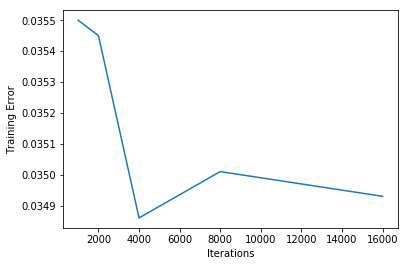

In [38]:
#PEGASOS Parameters - Regularization (lambda), iterations (T), min-batch size(batch_size)

T = [1000,2000,4000,8000,16000]
weight_length = max(rcv1.data.indices)+1

#Set parameters to optimum value
pegasos_lambda = 10**(-5)
min_batch_percent = 0.01

#calculate the lengths of the articles rows.
training_data_row_length = np.diff(training_data_indptr)
#append the length of the last article
training_data_row_length = np.append(training_data_row_length,len(training_data_indices)-training_data_indptr[len(training_data_indptr)-1])


#Choose random subset of training , initialize weight to zero
subset_length = int(min_batch_percent*training_len)

iteration_index = 0
w_pegasos_array = []
for iterations in T:
    print('T = ',iterations)
    w_pegasos = np.zeros(weight_length)
    for i in range(iterations):
        #adjust from i = 0:T-1 to i=1:T
        i += 1
        #choose random subset of artciles to use as min batch
        A_t = np.random.choice(training_len-1,subset_length)
    
        #initialize variable for sum of rows in A_t_dag
        grad_sum = np.zeros(weight_length)
        for index in A_t:
            row_data = training_data_data[training_data_indptr[index]:training_data_indptr[index]+training_data_row_length[index]]
            row_data_indices = training_data_indices[training_data_indptr[index]:training_data_indptr[index]+training_data_row_length[index]]
            
            #only dealing with weights corresponding to indices that are in this row. Update happens on these indices, then are
            # placed back into the overall w
            w_pegasos_row = w_pegasos[row_data_indices]
            
            
            if training_data_labels[index]*np.inner(w_pegasos_row,row_data) < 1:
                grad_sum[row_data_indices] += training_data_labels[index]*row_data
        
        grad = pegasos_lambda*w_pegasos - (1/subset_length)*grad_sum
        eta = 1/(i*pegasos_lambda)
        w_pegasos_t_prime = w_pegasos - eta*grad
        w_pegasos = min(1,((1/np.sqrt(pegasos_lambda))/np.sqrt(np.inner(w_pegasos_t_prime,w_pegasos_t_prime))))*w_pegasos_t_prime
        
        
    
    iteration_index += 1
    w_pegasos_array.append(w_pegasos)

#training error
training_errors_pegasos = []
for weights in w_pegasos_array:
    errors = 0
    for i in range(training_len):
        row_data = training_data_data[training_data_indptr[i]:training_data_indptr[i]+training_data_row_length[i]]
        row_data_indices = training_data_indices[training_data_indptr[i]:training_data_indptr[i]+training_data_row_length[i]]
            
        #only dealing with weights corresponding to indices that are in this row. Update happens on these indices, then are
        # placed back into the overall w
        w_pegasos_row = weights[row_data_indices]
    
    
        pred = np.sign(np.inner(w_pegasos_row,row_data))
    
        if not pred == training_data_labels[i]:
            errors += 1

    training_errors_pegasos.append(errors/training_len)
    
plt.plot(T,training_errors_pegasos)  
plt.xlabel("Iterations")
plt.ylabel("Training Error")

# Problem 3 - Adagrad

## Parameter Analysis - Min_batch size 

min_batch:  1e-05
min_batch:  0.0001
min_batch:  0.001
min_batch:  0.01
min_batch:  0.1


Text(0,0.5,'Training Error')

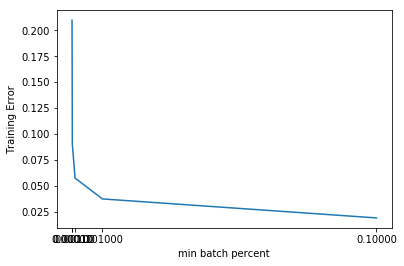

In [42]:
#Analysis on min_batch parameter optimization for fixed iteration length

T = 4000
weight_length = max(rcv1.data.indices)+1

min_batch_percent_range = [10**(-5),10**(-4),10**(-3),10**(-2),10**(-1)] #percent of training set to use as min-batch
#calculate the lengths of the articles rows.
training_data_row_length = np.diff(training_data_indptr)
#append the length of the last article
training_data_row_length = np.append(training_data_row_length,len(training_data_indices)-training_data_indptr[len(training_data_indptr)-1])

min_batch_index = 0
    
iteration_index = 0
w_adagrad_array = []
G_t = np.ones(weight_length)
for min_batch_percent in min_batch_percent_range:
    print('min_batch: ',min_batch_percent)
    subset_length = int(min_batch_percent*training_len)
    w_adagrad = np.zeros(weight_length)
    for i in range(iterations):
        #adjust from i = 0:T-1 to i=1:T
        i += 1
        
        #pick index at random
        #choose random subset of artciles to use as min batch
        A_t = np.random.choice(training_len-1,subset_length)
        
        for index in A_t:
            row_data = training_data_data[training_data_indptr[index]:training_data_indptr[index]+training_data_row_length[index]]
            row_data_indices = training_data_indices[training_data_indptr[index]:training_data_indptr[index]+training_data_row_length[index]]
            
            #only dealing with weights corresponding to indices that are in this row. Update happens on these indices, then are
            # placed back into the overall w
            w_adagrad_row = w_adagrad[row_data_indices]
            
            if training_data_labels[index]*np.inner(w_adagrad_row,row_data) < 1:
                G_t_row = np.reciprocal(G_t)[row_data_indices]
                w_adagrad_p = w_adagrad_row + (1/np.sqrt(iterations))*training_data_labels[index]* np.array([np.sqrt(G_t_row[r])*row_data[r] for r in range(len(row_data))])
                w_adagrad[row_data_indices] = w_adagrad_p
            
                ##UPDATE G_T
                G_t[row_data_indices] = G_t_row + np.diag(np.outer(-training_data_labels[index]*row_data,-training_data_labels[index]*row_data))
    
    iteration_index += 1
    w_adagrad_array.append(w_adagrad)

#training error
training_errors = []
for weights in w_adagrad_array:
    errors = 0
    for i in range(training_len):
        row_data = training_data_data[training_data_indptr[i]:training_data_indptr[i]+training_data_row_length[i]]
        row_data_indices = training_data_indices[training_data_indptr[i]:training_data_indptr[i]+training_data_row_length[i]]
            
        #only dealing with weights corresponding to indices that are in this row. Update happens on these indices, then are
        # placed back into the overall w
        w_adagrad_row = weights[row_data_indices]
    
    
        pred = np.sign(np.inner(w_adagrad_row,row_data))
    
        if not pred == training_data_labels[i]:
            errors += 1

    training_errors.append(errors/training_len)
    
plt.plot(min_batch_percent_range,training_errors) 
plt.xlabel("min batch percent")
plt.xticks(min_batch_percent_range)
plt.ylabel("Training Error")

## Parameter Estimation - Learning Rate 

eta: 0.001
eta: 0.01
eta: 0.1
eta: 1
eta: 10


NameError: name 'etarange' is not defined

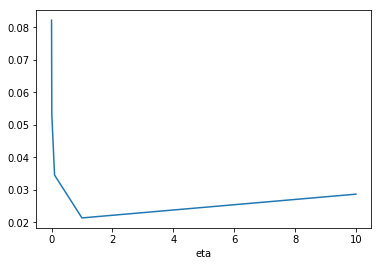

In [19]:
#Analysis on eta parameter optimization for fixed iteration length

T = 1000
weight_length = max(rcv1.data.indices)+1

min_batch_percentage = 0.01

eta_range = [0.001,0.01,0.1,1,10] 
#calculate the lengths of the articles rows.
training_data_row_length = np.diff(training_data_indptr)
#append the length of the last article
training_data_row_length = np.append(training_data_row_length,len(training_data_indices)-training_data_indptr[len(training_data_indptr)-1])

    
iteration_index = 0
w_adagrad_array = []
G_t = np.ones(weight_length)
subset_length = int(min_batch_percent*training_len)
for eta in eta_range:
    print("eta:",eta)
    w_adagrad = np.zeros(weight_length)
    for i in range(T):
        #adjust from i = 0:T-1 to i=1:T
        i += 1
        
        #pick index at random
        #choose random subset of artciles to use as min batch
        A_t = np.random.choice(training_len-1,subset_length)
        
        for index in A_t:
            row_data = training_data_data[training_data_indptr[index]:training_data_indptr[index]+training_data_row_length[index]]
            row_data_indices = training_data_indices[training_data_indptr[index]:training_data_indptr[index]+training_data_row_length[index]]
            
            #only dealing with weights corresponding to indices that are in this row. Update happens on these indices, then are
            # placed back into the overall w
            w_adagrad_row = w_adagrad[row_data_indices]
            
            if training_data_labels[index]*np.inner(w_adagrad_row,row_data) < 1:
                G_t_row = np.reciprocal(G_t)[row_data_indices]
                w_adagrad_p = w_adagrad_row + eta*training_data_labels[index]* np.array([np.sqrt(G_t_row[r])*row_data[r] for r in range(len(row_data))])
                w_adagrad[row_data_indices] = w_adagrad_p
            
                ##UPDATE G_T
                G_t[row_data_indices] = G_t_row + np.diag(np.outer(-training_data_labels[index]*row_data,-training_data_labels[index]*row_data))
    
    iteration_index += 1
    w_adagrad_array.append(w_adagrad)

#training error
training_errors = []
for weights in w_adagrad_array:
    errors = 0
    for i in range(training_len):
        row_data = training_data_data[training_data_indptr[i]:training_data_indptr[i]+training_data_row_length[i]]
        row_data_indices = training_data_indices[training_data_indptr[i]:training_data_indptr[i]+training_data_row_length[i]]
            
        #only dealing with weights corresponding to indices that are in this row. Update happens on these indices, then are
        # placed back into the overall w
        w_adagrad_row = weights[row_data_indices]
    
    
        pred = np.sign(np.inner(w_adagrad_row,row_data))
    
        if not pred == training_data_labels[i]:
            errors += 1

    training_errors.append(errors/training_len)
    
plt.plot(eta_range,training_errors) 
plt.xlabel("eta")
plt.xticks(etarange)
plt.ylabel("Training Error")

Text(0,0.5,'Training Error')

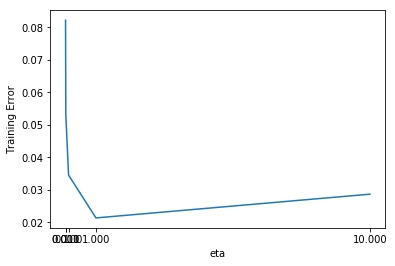

In [20]:
plt.plot(eta_range,training_errors) 
plt.xlabel("eta")
plt.xticks(eta_range)
plt.ylabel("Training Error")

## Training Error with set learning rate of 1 

T =  1000
T =  2000
T =  4000
T =  8000
T =  16000


Text(0,0.5,'Training Error')

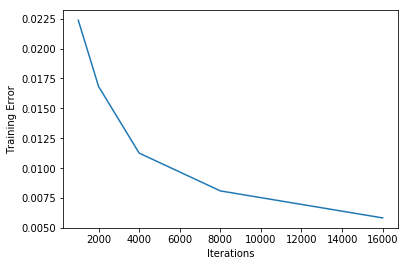

In [33]:
#Implement Adagrad algorithm - eta as 1

min_batch_percent = 0.01

T = [1000,2000,4000,8000,16000]
weight_length = max(rcv1.data.indices)+1

iteration_index = 0
w_adagrad_array = []
G_t = np.ones(weight_length)
subset_length = int(min_batch_percent*training_len)
for iterations in T:
    print('T = ',iterations)
    w_adagrad = np.zeros(weight_length)
    for i in range(iterations):
        #adjust from i = 0:T-1 to i=1:T
        i += 1
        
        #pick index at random
        #choose random subset of artciles to use as min batch
        A_t = np.random.choice(training_len-1,subset_length)
        
        for index in A_t:
            row_data = training_data_data[training_data_indptr[index]:training_data_indptr[index]+training_data_row_length[index]]
            row_data_indices = training_data_indices[training_data_indptr[index]:training_data_indptr[index]+training_data_row_length[index]]
            
            #only dealing with weights corresponding to indices that are in this row. Update happens on these indices, then are
            # placed back into the overall w
            w_adagrad_row = w_adagrad[row_data_indices]
            
            if training_data_labels[index]*np.inner(w_adagrad_row,row_data) < 1:
                G_t_row = np.reciprocal(G_t)[row_data_indices]
                w_adagrad_p = w_adagrad_row + training_data_labels[index]* np.array([np.sqrt(G_t_row[r])*row_data[r] for r in range(len(row_data))])
                w_adagrad[row_data_indices] = w_adagrad_p
            
                ##UPDATE G_T
                G_t[row_data_indices] = G_t_row + np.diag(np.outer(-training_data_labels[index]*row_data,-training_data_labels[index]*row_data))
    
    iteration_index += 1
    w_adagrad_array.append(w_adagrad)

#training error
training_errors_adagrad = []
for weights in w_adagrad_array:
    errors = 0
    for i in range(training_len):
        row_data = training_data_data[training_data_indptr[i]:training_data_indptr[i]+training_data_row_length[i]]
        row_data_indices = training_data_indices[training_data_indptr[i]:training_data_indptr[i]+training_data_row_length[i]]
            
        #only dealing with weights corresponding to indices that are in this row. Update happens on these indices, then are
        # placed back into the overall w
        w_adagrad_row = weights[row_data_indices]
    
    
        pred = np.sign(np.inner(w_adagrad_row,row_data))
    
        if not pred == training_data_labels[i]:
            errors += 1

    training_errors_adagrad.append(errors/training_len)
    
plt.plot(T,training_errors_adagrad)  
plt.xlabel("Iterations")
plt.ylabel("Training Error")

## Training error with learning rate set at 1/sqrt(T) 

T =  1000
T =  2000
T =  4000
T =  8000
T =  16000


Text(0,0.5,'Training Error')

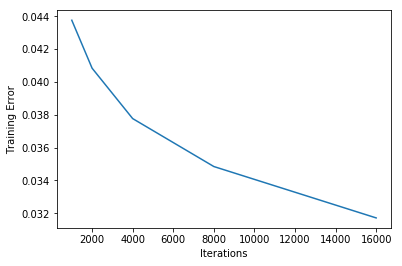

In [43]:
#Implement Adagrad algorithm - eta as 1/sqrt(T)

min_batch_percent = 0.01

T = [1000,2000,4000,8000,16000]
weight_length = max(rcv1.data.indices)+1

iteration_index = 0
w_adagrad_array = []
G_t = np.ones(weight_length)
subset_length = int(min_batch_percent*training_len)
for iterations in T:
    print('T = ',iterations)
    w_adagrad = np.zeros(weight_length)
    for i in range(iterations):
        #adjust from i = 0:T-1 to i=1:T
        i += 1
        
        #pick index at random
        #choose random subset of artciles to use as min batch
        A_t = np.random.choice(training_len-1,subset_length)
        
        for index in A_t:
            row_data = training_data_data[training_data_indptr[index]:training_data_indptr[index]+training_data_row_length[index]]
            row_data_indices = training_data_indices[training_data_indptr[index]:training_data_indptr[index]+training_data_row_length[index]]
            
            #only dealing with weights corresponding to indices that are in this row. Update happens on these indices, then are
            # placed back into the overall w
            w_adagrad_row = w_adagrad[row_data_indices]
            
            if training_data_labels[index]*np.inner(w_adagrad_row,row_data) < 1:
                G_t_row = np.reciprocal(G_t)[row_data_indices]
                w_adagrad_p = w_adagrad_row + (1/np.sqrt(iterations))*training_data_labels[index]* np.array([np.sqrt(G_t_row[r])*row_data[r] for r in range(len(row_data))])
                w_adagrad[row_data_indices] = w_adagrad_p
            
                ##UPDATE G_T
                G_t[row_data_indices] = G_t_row + np.diag(np.outer(-training_data_labels[index]*row_data,-training_data_labels[index]*row_data))
    
    iteration_index += 1
    w_adagrad_array.append(w_adagrad)

#training error
training_errors = []
for weights in w_adagrad_array:
    errors = 0
    for i in range(training_len):
        row_data = training_data_data[training_data_indptr[i]:training_data_indptr[i]+training_data_row_length[i]]
        row_data_indices = training_data_indices[training_data_indptr[i]:training_data_indptr[i]+training_data_row_length[i]]
            
        #only dealing with weights corresponding to indices that are in this row. Update happens on these indices, then are
        # placed back into the overall w
        w_adagrad_row = weights[row_data_indices]
    
    
        pred = np.sign(np.inner(w_adagrad_row,row_data))
    
        if not pred == training_data_labels[i]:
            errors += 1

    training_errors.append(errors/training_len)
    
plt.plot(T,training_errors)  
plt.xlabel("Iterations")
plt.ylabel("Training Error")

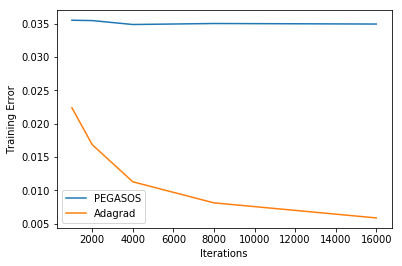

In [39]:
T = [1000,2000,4000,8000,16000]    
plt.plot(T,training_errors_pegasos,label='PEGASOS')  
plt.plot(T,training_errors_adagrad,label='Adagrad')   
plt.xlabel("Iterations")
plt.ylabel("Training Error")
plt.legend(loc='lower left')
plt.show()

# Problem 4 - Keras Neural Network

### Batch Generator for conversion from sparse to dense representation 

In [24]:
# batch generator inspired by https://www.kaggle.com/c/talkingdata-mobile-user-demographics/discussion/22567
# This batch generator is needed to feed dense representation of data to the neural networks for training
def batch_generator(sparse_mat, labels, batch_size):
    number_of_batches = np.ceil(sparse_mat.shape[0]/batch_size)
    counter = 0
    sample_index = np.arange(sparse_mat.shape[0])
    while True:
        batch_index = sample_index[batch_size*counter:batch_size*(counter+1)]
        sparse_mat_batch = sparse_mat[batch_index,:].toarray()
        labels_batch = labels[batch_index]
        counter += 1
        yield sparse_mat_batch, labels_batch
        if (counter == number_of_batches):
            counter = 0

## Prob 4a 

### One Layer 

In [454]:
#One layer
# Figure out how to get data in CSR format into NN - may need to iteratively make the row data dense representation 
sparse_mat = scipy.sparse.csr_matrix((training_data_data, training_data_indices, training_data_indptr))

#Create baseline architecture for neural network - 1 hidden layer
network = keras.Sequential()
network.add(keras.layers.Dense(100,input_shape=(weight_length,),activation='relu'))
network.add(keras.layers.Dense(1,input_shape=(100,),activation='sigmoid'))

#implement binary cross entropy loss for NN classification problem - but need to change labels from {-1,1} to {0,1}
nn_labels_list = [x if int(x) > 0 else 0 for x in label_vect_list]
nn_labels = np.array(nn_labels_list)
nn_training_data_labels = nn_labels[0:training_len-1]
nn_test_data_labels = nn_labels[training_len:article_num]

start_time = time.time()
network.compile(loss='binary_crossentropy', optimizer=tf.train.GradientDescentOptimizer(0.01), metrics=['accuracy'])
network.fit_generator(generator=batch_generator(sparse_mat, nn_training_data_labels, 100),epochs=5,steps_per_epoch=1000)
print("Training complete: It's been ",((time.time()-start_time)/60),"minutes")  

Epoch 1/5
1000/1000 [==============================] - 59s 59ms/step - loss: 0.6855 - acc: 0.5394
Epoch 2/5
1000/1000 [==============================] - 64s 64ms/step - loss: 0.6706 - acc: 0.5558
Epoch 3/5
1000/1000 [==============================] - 63s 63ms/step - loss: 0.6512 - acc: 0.6338
Epoch 4/5
1000/1000 [==============================] - 61s 61ms/step - loss: 0.6255 - acc: 0.7323
Epoch 5/5
1000/1000 [==============================] - 61s 61ms/step - loss: 0.5919 - acc: 0.8102
Training complete: It's been  5.148521149158478 minutes


### Two Layers 

In [455]:
#Two layer
# Figure out how to get data in CSR format into NN - may need to iteratively make the row data dense representation 
sparse_mat = scipy.sparse.csr_matrix((training_data_data, training_data_indices, training_data_indptr))

#Create baseline architecture for neural network - 1 hidden layer
network = keras.Sequential()
network.add(keras.layers.Dense(100,input_shape=(weight_length,),activation='relu'))
network.add(keras.layers.Dense(100,input_shape=(100,),activation='relu'))
network.add(keras.layers.Dense(1,input_shape=(100,),activation='sigmoid'))

#implement binary cross entropy loss for NN classification problem - but need to change labels from {-1,1} to {0,1}
nn_labels_list = [x if int(x) > 0 else 0 for x in label_vect_list]
nn_labels = np.array(nn_labels_list)
nn_training_data_labels = nn_labels[0:training_len-1]
nn_test_data_labels = nn_labels[training_len:article_num]

start_time = time.time()
#network.compile(loss='mse', optimizer=tf.train.GradientDescentOptimizer(0.01), metrics=['accuracy'])
network.compile(loss='binary_crossentropy', optimizer=tf.train.GradientDescentOptimizer(0.01), metrics=['accuracy'])
#network.fit(sparse_mat,nn_training_data_labels , epochs=5, batch_size=100)
network.fit_generator(generator=batch_generator(sparse_mat, nn_training_data_labels, 100),epochs=5,steps_per_epoch=1000)
print("Training complete: It's been ",((time.time()-start_time)/60),"minutes")  

Epoch 1/5
1000/1000 [==============================] - 56s 56ms/step - loss: 0.6882 - acc: 0.5377
Epoch 2/5
1000/1000 [==============================] - 59s 59ms/step - loss: 0.6779 - acc: 0.5408
Epoch 3/5
1000/1000 [==============================] - 61s 61ms/step - loss: 0.6556 - acc: 0.6163
Epoch 4/5
1000/1000 [==============================] - 62s 62ms/step - loss: 0.6014 - acc: 0.7817
Epoch 5/5
1000/1000 [==============================] - 61s 61ms/step - loss: 0.4853 - acc: 0.8762
Training complete: It's been  4.981606733798981 minutes


### Three Layers 

In [456]:
#Three layer
# Figure out how to get data in CSR format into NN - may need to iteratively make the row data dense representation 
sparse_mat = scipy.sparse.csr_matrix((training_data_data, training_data_indices, training_data_indptr))

#Create baseline architecture for neural network - 1 hidden layer
network = keras.Sequential()
network.add(keras.layers.Dense(100,input_shape=(weight_length,),activation='relu'))
network.add(keras.layers.Dense(100,input_shape=(100,),activation='relu'))
network.add(keras.layers.Dense(100,input_shape=(100,),activation='relu'))
network.add(keras.layers.Dense(1,input_shape=(100,),activation='sigmoid'))

#implement binary cross entropy loss for NN classification problem - but need to change labels from {-1,1} to {0,1}
nn_labels_list = [x if int(x) > 0 else 0 for x in label_vect_list]
nn_labels = np.array(nn_labels_list)
nn_training_data_labels = nn_labels[0:training_len-1]
nn_test_data_labels = nn_labels[training_len:article_num]

start_time = time.time()
#network.compile(loss='mse', optimizer=tf.train.GradientDescentOptimizer(0.01), metrics=['accuracy'])
network.compile(loss='binary_crossentropy', optimizer=tf.train.GradientDescentOptimizer(0.01), metrics=['accuracy'])
#network.fit(sparse_mat,nn_training_data_labels , epochs=5, batch_size=100)
network.fit_generator(generator=batch_generator(sparse_mat, nn_training_data_labels, 100),epochs=5,steps_per_epoch=1000)
print("Training complete: It's been ",((time.time()-start_time)/60),"minutes")  

Epoch 1/5
1000/1000 [==============================] - 58s 58ms/step - loss: 0.6881 - acc: 0.5374
Epoch 2/5
1000/1000 [==============================] - 60s 60ms/step - loss: 0.6732 - acc: 0.5498
Epoch 3/5
1000/1000 [==============================] - 64s 64ms/step - loss: 0.6173 - acc: 0.7212
Epoch 4/5
1000/1000 [==============================] - 64s 64ms/step - loss: 0.4209 - acc: 0.8836
Epoch 5/5
1000/1000 [==============================] - 67s 67ms/step - loss: 0.2414 - acc: 0.9194
Training complete: It's been  5.221806951363882 minutes


### Plot 

Text(0,0.5,'Training Error')

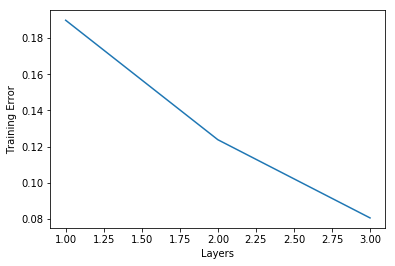

In [22]:
training_errors = [1-0.8102,1-0.8762,1-0.9194]
layers = [1,2,3]

plt.plot(layers,training_errors)
plt.xlabel("Layers")
plt.ylabel("Training Error")

## Prob 4b 

In [458]:
#Six layers - all tanh - 100 units
# Figure out how to get data in CSR format into NN - may need to iteratively make the row data dense representation 
sparse_mat = scipy.sparse.csr_matrix((training_data_data, training_data_indices, training_data_indptr))

#Create baseline architecture for neural network - 1 hidden layer
network = keras.Sequential()
network.add(keras.layers.Dense(100,input_shape=(weight_length,),activation='tanh'))
network.add(keras.layers.Dense(100,input_shape=(100,),activation='tanh'))
network.add(keras.layers.Dense(100,input_shape=(100,),activation='tanh'))
network.add(keras.layers.Dense(100,input_shape=(100,),activation='tanh'))
network.add(keras.layers.Dense(100,input_shape=(100,),activation='tanh'))
network.add(keras.layers.Dense(100,input_shape=(100,),activation='tanh'))
network.add(keras.layers.Dense(1,input_shape=(100,),activation='sigmoid'))

#implement binary cross entropy loss for NN classification problem - but need to change labels from {-1,1} to {0,1}
nn_labels_list = [x if int(x) > 0 else 0 for x in label_vect_list]
nn_labels = np.array(nn_labels_list)
nn_training_data_labels = nn_labels[0:training_len-1]
nn_test_data_labels = nn_labels[training_len:article_num]

start_time = time.time()
network.compile(loss='binary_crossentropy', optimizer=tf.train.GradientDescentOptimizer(0.01), metrics=['accuracy'])
network.fit_generator(generator=batch_generator(sparse_mat, nn_training_data_labels, 100),epochs=5,steps_per_epoch=1000)
print("Training complete: It's been ",((time.time()-start_time)/60),"minutes") 

Epoch 1/5
1000/1000 [==============================] - 86s 86ms/step - loss: 0.6827 - acc: 0.5518
Epoch 2/5
1000/1000 [==============================] - 85s 85ms/step - loss: 0.4375 - acc: 0.8108
Epoch 3/5
1000/1000 [==============================] - 77s 77ms/step - loss: 0.2102 - acc: 0.9205
Epoch 4/5
1000/1000 [==============================] - 80s 80ms/step - loss: 0.1732 - acc: 0.9357
Epoch 5/5
1000/1000 [==============================] - 86s 86ms/step - loss: 0.1570 - acc: 0.9422
Training complete: It's been  6.902369197209676 minutes


In [466]:
#Six layers - all relu - 100units
# Figure out how to get data in CSR format into NN - may need to iteratively make the row data dense representation 
sparse_mat = scipy.sparse.csr_matrix((training_data_data, training_data_indices, training_data_indptr))

#Create baseline architecture for neural network - 1 hidden layer
network = keras.Sequential()
network.add(keras.layers.Dense(100,input_shape=(weight_length,),activation='relu'))
network.add(keras.layers.Dense(100,input_shape=(100,),activation='relu'))
network.add(keras.layers.Dense(100,input_shape=(100,),activation='relu'))
network.add(keras.layers.Dense(100,input_shape=(100,),activation='relu'))
network.add(keras.layers.Dense(100,input_shape=(100,),activation='relu'))
network.add(keras.layers.Dense(100,input_shape=(100,),activation='relu'))
network.add(keras.layers.Dense(1,input_shape=(100,),activation='sigmoid'))

#implement binary cross entropy loss for NN classification problem - but need to change labels from {-1,1} to {0,1}
nn_labels_list = [x if int(x) > 0 else 0 for x in label_vect_list]
nn_labels = np.array(nn_labels_list)
nn_training_data_labels = nn_labels[0:training_len-1]
nn_test_data_labels = nn_labels[training_len:article_num]

start_time = time.time()
#network.compile(loss='mse', optimizer=tf.train.GradientDescentOptimizer(0.01), metrics=['accuracy'])
network.compile(loss='binary_crossentropy', optimizer=tf.train.GradientDescentOptimizer(0.01), metrics=['accuracy'])
#network.fit(sparse_mat,nn_training_data_labels , epochs=5, batch_size=100)
network.fit_generator(generator=batch_generator(sparse_mat, nn_training_data_labels, 100),epochs=5,steps_per_epoch=1000)
print("Training complete: It's been ",((time.time()-start_time)/60),"minutes") 

Epoch 1/5
1000/1000 [==============================] - 80s 80ms/step - loss: 0.6904 - acc: 0.5362
Epoch 2/5
1000/1000 [==============================] - 79s 79ms/step - loss: 0.6795 - acc: 0.5438
Epoch 3/5
1000/1000 [==============================] - 78s 78ms/step - loss: 0.5213 - acc: 0.7954
Epoch 4/5
1000/1000 [==============================] - 80s 80ms/step - loss: 0.2348 - acc: 0.9111
Epoch 5/5
1000/1000 [==============================] - 83s 83ms/step - loss: 0.1834 - acc: 0.9326
Training complete: It's been  6.669677297274272 minutes


In [459]:
#Six layers - alternate tanh relu - 100 units
# Figure out how to get data in CSR format into NN - may need to iteratively make the row data dense representation 
sparse_mat = scipy.sparse.csr_matrix((training_data_data, training_data_indices, training_data_indptr))

#Create baseline architecture for neural network - 1 hidden layer
network = keras.Sequential()
network.add(keras.layers.Dense(100,input_shape=(weight_length,),activation='tanh'))
network.add(keras.layers.Dense(100,input_shape=(100,),activation='relu'))
network.add(keras.layers.Dense(100,input_shape=(100,),activation='tanh'))
network.add(keras.layers.Dense(100,input_shape=(100,),activation='relu'))
network.add(keras.layers.Dense(100,input_shape=(100,),activation='tanh'))
network.add(keras.layers.Dense(100,input_shape=(100,),activation='relu'))
network.add(keras.layers.Dense(1,input_shape=(100,),activation='sigmoid'))

#implement binary cross entropy loss for NN classification problem - but need to change labels from {-1,1} to {0,1}
nn_labels_list = [x if int(x) > 0 else 0 for x in label_vect_list]
nn_labels = np.array(nn_labels_list)
nn_training_data_labels = nn_labels[0:training_len-1]
nn_test_data_labels = nn_labels[training_len:article_num]

start_time = time.time()
#network.compile(loss='mse', optimizer=tf.train.GradientDescentOptimizer(0.01), metrics=['accuracy'])
network.compile(loss='binary_crossentropy', optimizer=tf.train.GradientDescentOptimizer(0.01), metrics=['accuracy'])
#network.fit(sparse_mat,nn_training_data_labels , epochs=5, batch_size=100)
network.fit_generator(generator=batch_generator(sparse_mat, nn_training_data_labels, 100),epochs=5,steps_per_epoch=1000)
print("Training complete: It's been ",((time.time()-start_time)/60),"minutes") 

Epoch 1/5
1000/1000 [==============================] - 85s 85ms/step - loss: 0.6760 - acc: 0.5828
Epoch 2/5
1000/1000 [==============================] - 80s 80ms/step - loss: 0.3864 - acc: 0.8567
Epoch 3/5
1000/1000 [==============================] - 77s 77ms/step - loss: 0.2074 - acc: 0.9222
Epoch 4/5
1000/1000 [==============================] - 81s 81ms/step - loss: 0.1730 - acc: 0.9368
Epoch 5/5
1000/1000 [==============================] - 76s 76ms/step - loss: 0.1573 - acc: 0.9432
Training complete: It's been  6.647776341438293 minutes


In [467]:
#Six layers - alternate tanh relu - 200 units
# Figure out how to get data in CSR format into NN - may need to iteratively make the row data dense representation 
sparse_mat = scipy.sparse.csr_matrix((training_data_data, training_data_indices, training_data_indptr))

#Create baseline architecture for neural network - 1 hidden layer
network = keras.Sequential()
network.add(keras.layers.Dense(200,input_shape=(weight_length,),activation='tanh'))
network.add(keras.layers.Dense(200,input_shape=(200,),activation='relu'))
network.add(keras.layers.Dense(200,input_shape=(200,),activation='tanh'))
network.add(keras.layers.Dense(200,input_shape=(200,),activation='relu'))
network.add(keras.layers.Dense(200,input_shape=(200,),activation='tanh'))
network.add(keras.layers.Dense(200,input_shape=(200,),activation='relu'))
network.add(keras.layers.Dense(1,input_shape=(200,),activation='sigmoid'))

#implement binary cross entropy loss for NN classification problem - but need to change labels from {-1,1} to {0,1}
nn_labels_list = [x if int(x) > 0 else 0 for x in label_vect_list]
nn_labels = np.array(nn_labels_list)
nn_training_data_labels = nn_labels[0:training_len-1]
nn_test_data_labels = nn_labels[training_len:article_num]

start_time = time.time()
#network.compile(loss='mse', optimizer=tf.train.GradientDescentOptimizer(0.01), metrics=['accuracy'])
network.compile(loss='binary_crossentropy', optimizer=tf.train.GradientDescentOptimizer(0.01), metrics=['accuracy'])
#network.fit(sparse_mat,nn_training_data_labels , epochs=5, batch_size=100)
network.fit_generator(generator=batch_generator(sparse_mat, nn_training_data_labels, 100),epochs=5,steps_per_epoch=1000)
print("Training complete: It's been ",((time.time()-start_time)/60),"minutes") 

Epoch 1/5
1000/1000 [==============================] - 86s 86ms/step - loss: 0.6854 - acc: 0.5414
Epoch 2/5
1000/1000 [==============================] - 79s 79ms/step - loss: 0.5198 - acc: 0.7788
Epoch 3/5
1000/1000 [==============================] - 79s 79ms/step - loss: 0.2271 - acc: 0.9133
Epoch 4/5
1000/1000 [==============================] - 80s 80ms/step - loss: 0.1795 - acc: 0.9344
Epoch 5/5
1000/1000 [==============================] - 84s 84ms/step - loss: 0.1610 - acc: 0.9419
Training complete: It's been  6.783951278527578 minutes


In [462]:
#Six layers - all relu - 200 units per layer
# Figure out how to get data in CSR format into NN - may need to iteratively make the row data dense representation 
sparse_mat = scipy.sparse.csr_matrix((training_data_data, training_data_indices, training_data_indptr))

#Create baseline architecture for neural network - 1 hidden layer
network = keras.Sequential()
network.add(keras.layers.Dense(200,input_shape=(weight_length,),activation='relu'))
network.add(keras.layers.Dense(200,input_shape=(200,),activation='relu'))
network.add(keras.layers.Dense(200,input_shape=(200,),activation='relu'))
network.add(keras.layers.Dense(200,input_shape=(200,),activation='relu'))
network.add(keras.layers.Dense(200,input_shape=(200,),activation='relu'))
network.add(keras.layers.Dense(200,input_shape=(200,),activation='relu'))
network.add(keras.layers.Dense(1,input_shape=(200,),activation='sigmoid'))

#implement binary cross entropy loss for NN classification problem - but need to change labels from {-1,1} to {0,1}
nn_labels_list = [x if int(x) > 0 else 0 for x in label_vect_list]
nn_labels = np.array(nn_labels_list)
nn_training_data_labels = nn_labels[0:training_len-1]
nn_test_data_labels = nn_labels[training_len:article_num]

start_time = time.time()
#network.compile(loss='mse', optimizer=tf.train.GradientDescentOptimizer(0.01), metrics=['accuracy'])
network.compile(loss='binary_crossentropy', optimizer=tf.train.GradientDescentOptimizer(0.01), metrics=['accuracy'])
#network.fit(sparse_mat,nn_training_data_labels , epochs=5, batch_size=100)
network.fit_generator(generator=batch_generator(sparse_mat, nn_training_data_labels, 100),epochs=5,steps_per_epoch=1000)
print("Training complete: It's been ",((time.time()-start_time)/60),"minutes") 

Epoch 1/5
1000/1000 [==============================] - 92s 92ms/step - loss: 0.6898 - acc: 0.5363
Epoch 2/5
1000/1000 [==============================] - 112s 112ms/step - loss: 0.6712 - acc: 0.5804
Epoch 3/5
1000/1000 [==============================] - 105s 105ms/step - loss: 0.4225 - acc: 0.8566
Epoch 4/5
1000/1000 [==============================] - 108s 108ms/step - loss: 0.2154 - acc: 0.9193
Epoch 5/5
1000/1000 [==============================] - 111s 111ms/step - loss: 0.1765 - acc: 0.9356
Training complete: It's been  8.783600572745005 minutes


In [464]:
#Six layers - all tanh - 200 units per layer
# Figure out how to get data in CSR format into NN - may need to iteratively make the row data dense representation 
sparse_mat = scipy.sparse.csr_matrix((training_data_data, training_data_indices, training_data_indptr))

#Create baseline architecture for neural network - 1 hidden layer
network = keras.Sequential()
network.add(keras.layers.Dense(200,input_shape=(weight_length,),activation='tanh'))
network.add(keras.layers.Dense(200,input_shape=(200,),activation='tanh'))
network.add(keras.layers.Dense(200,input_shape=(200,),activation='tanh'))
network.add(keras.layers.Dense(200,input_shape=(200,),activation='tanh'))
network.add(keras.layers.Dense(200,input_shape=(200,),activation='tanh'))
network.add(keras.layers.Dense(200,input_shape=(200,),activation='tanh'))
network.add(keras.layers.Dense(1,input_shape=(200,),activation='sigmoid'))

#implement binary cross entropy loss for NN classification problem - but need to change labels from {-1,1} to {0,1}
nn_labels_list = [x if int(x) > 0 else 0 for x in label_vect_list]
nn_labels = np.array(nn_labels_list)
nn_training_data_labels = nn_labels[0:training_len-1]
nn_test_data_labels = nn_labels[training_len:article_num]

start_time = time.time()
#network.compile(loss='mse', optimizer=tf.train.GradientDescentOptimizer(0.01), metrics=['accuracy'])
network.compile(loss='binary_crossentropy', optimizer=tf.train.GradientDescentOptimizer(0.01), metrics=['accuracy'])
#network.fit(sparse_mat,nn_training_data_labels , epochs=5, batch_size=100)
network.fit_generator(generator=batch_generator(sparse_mat, nn_training_data_labels, 100),epochs=5,steps_per_epoch=1000)
print("Training complete: It's been ",((time.time()-start_time)/60),"minutes") 

Epoch 1/5
1000/1000 [==============================] - 108s 108ms/step - loss: 0.6815 - acc: 0.5582
Epoch 2/5
1000/1000 [==============================] - 107s 107ms/step - loss: 0.4155 - acc: 0.8235
Epoch 3/5
1000/1000 [==============================] - 107s 107ms/step - loss: 0.2082 - acc: 0.9214
Epoch 4/5
1000/1000 [==============================] - 107s 107ms/step - loss: 0.1723 - acc: 0.9361
Epoch 5/5
1000/1000 [==============================] - 107s 107ms/step - loss: 0.1566 - acc: 0.9423
Training complete: It's been  8.942666391531626 minutes


In [465]:
#three layers - all relu - mse error
# Figure out how to get data in CSR format into NN - may need to iteratively make the row data dense representation 
sparse_mat = scipy.sparse.csr_matrix((training_data_data, training_data_indices, training_data_indptr))

#Create baseline architecture for neural network - 1 hidden layer
network = keras.Sequential()
network.add(keras.layers.Dense(100,input_shape=(weight_length,),activation='relu'))
network.add(keras.layers.Dense(100,input_shape=(100,),activation='relu'))
network.add(keras.layers.Dense(100,input_shape=(100,),activation='relu'))
network.add(keras.layers.Dense(1,input_shape=(100,),activation='sigmoid'))

#implement binary cross entropy loss for NN classification problem - but need to change labels from {-1,1} to {0,1}
nn_labels_list = [x if int(x) > 0 else 0 for x in label_vect_list]
nn_labels = np.array(nn_labels_list)
nn_training_data_labels = nn_labels[0:training_len-1]
nn_test_data_labels = nn_labels[training_len:article_num]

start_time = time.time()
network.compile(loss='mse', optimizer=tf.train.GradientDescentOptimizer(0.01), metrics=['accuracy'])
#network.compile(loss='binary_crossentropy', optimizer=tf.train.GradientDescentOptimizer(0.01), metrics=['accuracy'])
#network.fit(sparse_mat,nn_training_data_labels , epochs=5, batch_size=100)
network.fit_generator(generator=batch_generator(sparse_mat, nn_training_data_labels, 100),epochs=5,steps_per_epoch=1000)
print("Training complete: It's been ",((time.time()-start_time)/60),"minutes") 

Epoch 1/5
1000/1000 [==============================] - 82s 82ms/step - loss: 0.2486 - acc: 0.5375
Epoch 2/5
1000/1000 [==============================] - 78s 78ms/step - loss: 0.2468 - acc: 0.5391
Epoch 3/5
1000/1000 [==============================] - 81s 81ms/step - loss: 0.2435 - acc: 0.5391
Epoch 4/5
1000/1000 [==============================] - 83s 83ms/step - loss: 0.2378 - acc: 0.5555
Epoch 5/5
1000/1000 [==============================] - 82s 82ms/step - loss: 0.2266 - acc: 0.6615
Training complete: It's been  6.787567714850108 minutes


In [469]:
#Six layers - all relu - 300 units per layer
# Figure out how to get data in CSR format into NN - may need to iteratively make the row data dense representation 
sparse_mat = scipy.sparse.csr_matrix((training_data_data, training_data_indices, training_data_indptr))

#Create baseline architecture for neural network - 1 hidden layer
network = keras.Sequential()
network.add(keras.layers.Dense(300,input_shape=(weight_length,),activation='relu'))
network.add(keras.layers.Dense(300,input_shape=(300,),activation='relu'))
network.add(keras.layers.Dense(300,input_shape=(300,),activation='relu'))
network.add(keras.layers.Dense(300,input_shape=(300,),activation='relu'))
network.add(keras.layers.Dense(300,input_shape=(300,),activation='relu'))
network.add(keras.layers.Dense(300,input_shape=(300,),activation='relu'))
network.add(keras.layers.Dense(1,input_shape=(300,),activation='sigmoid'))

#implement binary cross entropy loss for NN classification problem - but need to change labels from {-1,1} to {0,1}
nn_labels_list = [x if int(x) > 0 else 0 for x in label_vect_list]
nn_labels = np.array(nn_labels_list)
nn_training_data_labels = nn_labels[0:training_len-1]
nn_test_data_labels = nn_labels[training_len:article_num]

start_time = time.time()
#network.compile(loss='mse', optimizer=tf.train.GradientDescentOptimizer(0.01), metrics=['accuracy'])
network.compile(loss='binary_crossentropy', optimizer=tf.train.GradientDescentOptimizer(0.01), metrics=['accuracy'])
#network.fit(sparse_mat,nn_training_data_labels , epochs=5, batch_size=100)
network.fit_generator(generator=batch_generator(sparse_mat, nn_training_data_labels, 100),epochs=5,steps_per_epoch=1000)
print("Training complete: It's been ",((time.time()-start_time)/60),"minutes") 

Epoch 1/5
1000/1000 [==============================] - 108s 108ms/step - loss: 0.6901 - acc: 0.5362
Epoch 2/5
1000/1000 [==============================] - 110s 110ms/step - loss: 0.6773 - acc: 0.5542
Epoch 3/5
1000/1000 [==============================] - 109s 109ms/step - loss: 0.4762 - acc: 0.8261
Epoch 4/5
1000/1000 [==============================] - 110s 110ms/step - loss: 0.2258 - acc: 0.9143
Epoch 5/5
1000/1000 [==============================] - 110s 110ms/step - loss: 0.1797 - acc: 0.9345
Training complete: It's been  9.101565364996592 minutes


In [470]:
#Six layers - all sigmoid - 100 units
# Figure out how to get data in CSR format into NN - may need to iteratively make the row data dense representation 
sparse_mat = scipy.sparse.csr_matrix((training_data_data, training_data_indices, training_data_indptr))

#Create baseline architecture for neural network - 1 hidden layer
network = keras.Sequential()
network.add(keras.layers.Dense(100,input_shape=(weight_length,),activation='sigmoid'))
network.add(keras.layers.Dense(100,input_shape=(100,),activation='sigmoid'))
network.add(keras.layers.Dense(100,input_shape=(100,),activation='sigmoid'))
network.add(keras.layers.Dense(100,input_shape=(100,),activation='sigmoid'))
network.add(keras.layers.Dense(100,input_shape=(100,),activation='sigmoid'))
network.add(keras.layers.Dense(100,input_shape=(100,),activation='sigmoid'))
network.add(keras.layers.Dense(1,input_shape=(100,),activation='sigmoid'))

#implement binary cross entropy loss for NN classification problem - but need to change labels from {-1,1} to {0,1}
nn_labels_list = [x if int(x) > 0 else 0 for x in label_vect_list]
nn_labels = np.array(nn_labels_list)
nn_training_data_labels = nn_labels[0:training_len-1]
nn_test_data_labels = nn_labels[training_len:article_num]

start_time = time.time()
#network.compile(loss='mse', optimizer=tf.train.GradientDescentOptimizer(0.01), metrics=['accuracy'])
network.compile(loss='binary_crossentropy', optimizer=tf.train.GradientDescentOptimizer(0.01), metrics=['accuracy'])
#network.fit(sparse_mat,nn_training_data_labels , epochs=5, batch_size=100)
network.fit_generator(generator=batch_generator(sparse_mat, nn_training_data_labels, 100),epochs=5,steps_per_epoch=1000)
print("Training complete: It's been ",((time.time()-start_time)/60),"minutes") 

Epoch 1/5
1000/1000 [==============================] - 84s 84ms/step - loss: 0.6911 - acc: 0.5297
Epoch 2/5
1000/1000 [==============================] - 79s 79ms/step - loss: 0.6911 - acc: 0.5292
Epoch 3/5
1000/1000 [==============================] - 81s 81ms/step - loss: 0.6911 - acc: 0.5303
Epoch 4/5
1000/1000 [==============================] - 80s 80ms/step - loss: 0.6911 - acc: 0.5303
Epoch 5/5
1000/1000 [==============================] - 80s 80ms/step - loss: 0.6911 - acc: 0.5303
Training complete: It's been  6.732307982444763 minutes


# Problem 5

## Best PEGASOS Test

In [40]:
#PEGASOS Parameters - Regularization (lambda), iterations (T), min-batch size(batch_size)

print("PEGASOS Started")
start_time = time.time()
T = 4000 #Choose iterations that gives best tradeoff between runtime, overfitting to training data, etc.
weight_length = max(rcv1.data.indices)+1

#Set parameters to optimum value
pegasos_lambda = 10**(-5)
min_batch_percent = 0.01

#calculate the lengths of the articles rows.
training_data_row_length = np.diff(training_data_indptr)
test_data_row_length = np.diff(test_data_indptr)
#append the length of the last article
training_data_row_length = np.append(training_data_row_length,len(training_data_indices)-training_data_indptr[len(training_data_indptr)-1])
test_data_row_length = np.append(test_data_row_length,len(test_data_indices)-test_data_indptr[len(test_data_indptr)-1])


#Choose random subset of training , initialize weight to zero
subset_length = int(min_batch_percent*training_len)


iteration_index = 0
w = np.zeros(weight_length)
for i in range(T):
    #adjust from i = 0:T-1 to i=1:T
    i += 1
    #choose random subset of artciles to use as min batch
    A_t = np.random.choice(training_len-1,subset_length)
    
    #initialize variable for sum of rows in A_t_dag
    grad_sum = np.zeros(weight_length)
    for index in A_t:
        row_data = training_data_data[training_data_indptr[index]:training_data_indptr[index]+training_data_row_length[index]]
        row_data_indices = training_data_indices[training_data_indptr[index]:training_data_indptr[index]+training_data_row_length[index]]
            
        #only dealing with weights corresponding to indices that are in this row. Update happens on these indices, then are
        # placed back into the overall w
        w_row = w[row_data_indices]
            
            
        if training_data_labels[index]*np.inner(w_row,row_data) < 1:
            grad_sum[row_data_indices] += training_data_labels[index]*row_data
        
    grad = pegasos_lambda*w - (1/subset_length)*grad_sum
    eta = 1/(i*pegasos_lambda)
    w_t_prime = w - eta*grad
    w = min(1,((1/np.sqrt(pegasos_lambda))/np.sqrt(np.inner(w_t_prime,w_t_prime))))*w_t_prime
        
        


#test error
errors = 0
for i in range(test_data_len):
    row_data = test_data_data[test_data_indptr[i]:test_data_indptr[i]+test_data_row_length[i]]
    row_data_indices = test_data_indices[test_data_indptr[i]:test_data_indptr[i]+test_data_row_length[i]]
            
    #only dealing with weights corresponding to indices that are in this row. Update happens on these indices, then are
    # placed back into the overall w
    w_row = w[row_data_indices]
    
    
    pred = np.sign(np.inner(w_row,row_data))
    
    if not pred == test_data_labels[i]:
        errors += 1

test_error_pegasos = (errors/test_data_len)
    
print("PEGASOS Test complete. Test error: ",test_error_pegasos," It's been ",((time.time()-start_time)/60),"minutes") 

PEGASOS Started
PEGASOS Test complete. Test error:  0.5689699963799749  It's been  1.6358597834904989 minutes


## Best Adagrad Test

In [57]:
#Implement Adagrad algorithm 

print("Adagrad start")
start_time = time.time()
min_batch_percent = 0.01
subset_length = int(min_batch_percent*training_len)
T = 8000
weight_length = max(rcv1.data.indices)+1

#calculate the lengths of the articles rows.
training_data_row_length = np.diff(training_data_indptr)
test_data_row_length = np.diff(test_data_indptr)
#append the length of the last article
training_data_row_length = np.append(training_data_row_length,len(training_data_indices)-training_data_indptr[len(training_data_indptr)-1])
test_data_row_length = np.append(test_data_row_length,len(test_data_indices)-test_data_indptr[len(test_data_indptr)-1])


#training
G_t = np.ones(weight_length)
w_adagrad = np.zeros(weight_length)
for i in range(T):
    #adjust from i = 0:T-1 to i=1:T
    i += 1
        
    #pick index at random
    #choose random subset of artciles to use as min batch
    A_t = np.random.choice(training_len-1,subset_length)
        
    for index in A_t:
        row_data = training_data_data[training_data_indptr[index]:training_data_indptr[index]+training_data_row_length[index]]
        row_data_indices = training_data_indices[training_data_indptr[index]:training_data_indptr[index]+training_data_row_length[index]]
            
        #only dealing with weights corresponding to indices that are in this row. Update happens on these indices, then are
        # placed back into the overall w
        w_adagrad_row = w_adagrad[row_data_indices]
            
        if training_data_labels[index]*np.inner(w_adagrad_row,row_data) < 1:
            G_t_row = np.reciprocal(G_t)[row_data_indices]
            w_adagrad_p = w_adagrad_row + (1/np.sqrt(T))*training_data_labels[index]* np.array([np.sqrt(G_t_row[r])*row_data[r] for r in range(len(row_data))])
            w_adagrad[row_data_indices] = w_adagrad_p
            
            ##UPDATE G_T
            G_t[row_data_indices] = G_t_row + np.diag(np.outer(-training_data_labels[index]*row_data,-training_data_labels[index]*row_data))

            
print("Adagrad Training complete. It's been ",((time.time()-start_time)/60),"minutes since start")
#test error
errors = 0
for i in range(test_data_len):
    row_data = test_data_data[test_data_indptr[i]:test_data_indptr[i]+test_data_row_length[i]]
    row_data_indices = test_data_indices[test_data_indptr[i]:test_data_indptr[i]+test_data_row_length[i]]
            
    #only dealing with weights corresponding to indices that are in this row. Update happens on these indices, then are
    # placed back into the overall w
    w_adagrad_row = w_adagrad[row_data_indices]
    
    
    pred = np.sign(np.inner(w_adagrad_row,row_data))
    
    if not pred == test_data_labels[i]:
        errors += 1

    test_error_adagrad = (errors/test_data_len)
    
print("Adagrad Test complete. Test error: ",test_error_adagrad," It's been ",((time.time()-start_time)/60),"minutes since start") 

Adagrad start
Adagrad Training complete. It's been  10.940901112556457 minutes since start
Adagrad Test complete. Test error:  0.569121895473549  It's been  11.065836588541666 minutes since start


In [42]:
#Implement Adagrad algorithm 

print("Adagrad start")
start_time = time.time()
min_batch_percent = 0.01
subset_length = int(min_batch_percent*training_len)
T = 8000
weight_length = max(rcv1.data.indices)+1

#calculate the lengths of the articles rows.
training_data_row_length = np.diff(training_data_indptr)
test_data_row_length = np.diff(test_data_indptr)
#append the length of the last article
training_data_row_length = np.append(training_data_row_length,len(training_data_indices)-training_data_indptr[len(training_data_indptr)-1])
test_data_row_length = np.append(test_data_row_length,len(test_data_indices)-test_data_indptr[len(test_data_indptr)-1])


#training
G_t = np.ones(weight_length)
w_adagrad = np.zeros(weight_length)
for i in range(T):
    #adjust from i = 0:T-1 to i=1:T
    i += 1
        
    #pick index at random
    #choose random subset of artciles to use as min batch
    A_t = np.random.choice(training_len-1,subset_length)
        
    for index in A_t:
        row_data = training_data_data[training_data_indptr[index]:training_data_indptr[index]+training_data_row_length[index]]
        row_data_indices = training_data_indices[training_data_indptr[index]:training_data_indptr[index]+training_data_row_length[index]]
            
        #only dealing with weights corresponding to indices that are in this row. Update happens on these indices, then are
        # placed back into the overall w
        w_adagrad_row = w_adagrad[row_data_indices]
            
        if training_data_labels[index]*np.inner(w_adagrad_row,row_data) < 1:
            G_t_row = np.reciprocal(G_t)[row_data_indices]
            w_adagrad_p = w_adagrad_row + training_data_labels[index]* np.array([np.sqrt(G_t_row[r])*row_data[r] for r in range(len(row_data))])
            w_adagrad[row_data_indices] = w_adagrad_p
            
            ##UPDATE G_T
            G_t[row_data_indices] = G_t_row + np.diag(np.outer(-training_data_labels[index]*row_data,-training_data_labels[index]*row_data))

            
print("Adagrad Training complete. It's been ",((time.time()-start_time)/60),"minutes since start")
#test error
errors = 0
for i in range(test_data_len):
    row_data = test_data_data[test_data_indptr[i]:test_data_indptr[i]+test_data_row_length[i]]
    row_data_indices = test_data_indices[test_data_indptr[i]:test_data_indptr[i]+test_data_row_length[i]]
            
    #only dealing with weights corresponding to indices that are in this row. Update happens on these indices, then are
    # placed back into the overall w
    w_adagrad_row = w_adagrad[row_data_indices]
    
    

    pred = np.sign(np.inner(w_adagrad_row,row_data))
    
    if not pred == test_data_labels[i]:
        errors += 1

test_error_adagrad = (errors/test_data_len)
    
print("Adagrad Test complete. Test error: ",test_error_adagrad," It's been ",((time.time()-start_time)/60),"minutes since start") 

Adagrad start
Adagrad Training complete. It's been  4.8646095832188925 minutes since start
Adagrad Test complete. Test error:  0.5670890029315105  It's been  5.011616726716359 minutes since start


## NN Test 

In [25]:
#Six layers - alternate tanh relu - 200 units
# Figure out how to get data in CSR format into NN - may need to iteratively make the row data dense representation 
sparse_mat = scipy.sparse.csr_matrix((training_data_data, training_data_indices, training_data_indptr))
sparse_mat_test = scipy.sparse.csr_matrix((test_data_data, test_data_indices, test_data_indptr - test_data_indptr[0]))

#Create baseline architecture for neural network - 1 hidden layer
network = keras.Sequential()
network.add(keras.layers.Dense(100,input_shape=(weight_length,),activation='tanh'))
network.add(keras.layers.Dense(100,input_shape=(100,),activation='relu'))
network.add(keras.layers.Dense(100,input_shape=(100,),activation='tanh'))
network.add(keras.layers.Dense(100,input_shape=(100,),activation='relu'))
network.add(keras.layers.Dense(100,input_shape=(100,),activation='tanh'))
network.add(keras.layers.Dense(100,input_shape=(100,),activation='relu'))
network.add(keras.layers.Dense(1,input_shape=(100,),activation='sigmoid'))

#implement binary cross entropy loss for NN classification problem - but need to change labels from {-1,1} to {0,1}
nn_labels_list = [x if int(x) > 0 else 0 for x in label_vect_list]
nn_labels = np.array(nn_labels_list)
nn_training_data_labels = nn_labels[0:training_len-1]
nn_test_data_labels = nn_labels[training_len:article_num]

start_time = time.time()
network.compile(loss='binary_crossentropy', optimizer=tf.train.GradientDescentOptimizer(0.01), metrics=['accuracy'])
network.fit_generator(generator=batch_generator(sparse_mat, nn_training_data_labels, 100),epochs=5,steps_per_epoch=1000)
print("Training complete: It's been ",((time.time()-start_time)/60),"minutes") 
start_time = time.time()
(nn_test_loss,nn_test_acc) = network.evaluate_generator(generator=batch_generator(sparse_mat_test, nn_test_data_labels, 100),steps=len(nn_test_data_labels)/100)
nn_test_error = 1-nn_test_acc
print("NN Test complete. Test Error is: ",nn_test_error," It's been ",((time.time()-start_time)/60),"minutes") 

Epoch 1/5
1000/1000 [==============================] - 52s 52ms/step - loss: 0.6890 - acc: 0.5366
Epoch 2/5
1000/1000 [==============================] - 57s 57ms/step - loss: 0.6473 - acc: 0.6560
Epoch 3/5
1000/1000 [==============================] - 60s 60ms/step - loss: 0.3034 - acc: 0.8915
Epoch 4/5
1000/1000 [==============================] - 60s 60ms/step - loss: 0.1950 - acc: 0.9275
Epoch 5/5
1000/1000 [==============================] - 58s 58ms/step - loss: 0.1683 - acc: 0.9391
Training complete: It's been  4.79215921163559 minutes
NN Test complete. Test Error is:  0.06446776729280634  It's been  3.7442187786102297 minutes
